In [1]:
#Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import albumentations as A
import torchvision.transforms as T


!pip install openai-clip

!pip install open_clip_torch
import open_clip
import cv2
from PIL import Image
import yaml
import math

# Model Creation Libraries
import os #to import custom models

import torch
import torch.nn as nn
import torch.nn.functional as F

# Model Training Libraries
from torch.utils.data import DataLoader, Dataset, ConcatDataset
!pip install faiss-cpu
!pip install faiss-gpu
import faiss
#from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
#!pip install loguru
#from loguru import logger
from sklearn.preprocessing import normalize
from torch.utils.data import ConcatDataset

import timm
import glob
from transformers import (get_linear_schedule_with_warmup, 
                          get_constant_schedule,
                          get_cosine_schedule_with_warmup, 
                          get_cosine_with_hard_restarts_schedule_with_warmup,
                          get_constant_schedule_with_warmup)
import gc
import transformers
from transformers import CLIPProcessor, CLIPVisionModel,  CLIPVisionConfig

#Error Handling Libraries
!pip install pytorch-metric-learning
from pytorch_metric_learning import losses
from sklearn.model_selection import train_test_split

import copy
from albumentations.pytorch.transforms import ToTensorV2
import time
#from torchvision import transforms
import random
%load_ext autoreload
%autoreload 2

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 15.5 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 5.0 MB/s eta 0:00:00
  Created wheel for openai-clip: filename=openai_clip-1.0.1-py3-none-any.whl size=1368607 sha256=ecff8d8160e15b7ca8116ad870d1e7de867ab7a12e69d69ff8a0575f57df10b4
  Stored in directory: /root/.cache/pip/wheels/08/77/8e/8d2f862df6bf7fb4e2007062d2cbaeae49862ec7b56d041229
Successfully built openai-clip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 16.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 62.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 13.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 2.9 MB/s eta 0:00:0000:01


In [2]:
"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
"""

'\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\ndevice\n'

In [3]:
#open_clip.list_pretrained()

## Configuration Setup

In [4]:
class CFG:
    model_name = 'ViT-H-14'           #Neural network model architecture
    model_data = 'laion2b_s32b_b79k'  #Pretrained model
    samples_per_class = 50            #Class balancing
    n_classes = 0                     
    min_samples = 4                   
    image_size = 224                  #pixel 224 x 224
    hidden_layer = 1024                #number of neurons in a hidden layer
    seed = 42                         
    workers = 12                      #number of CPU cores ; parallel tasks
    train_batch_size = 4              
    valid_batch_size = 8             
    emb_size = 512                    
    vit_bb_lr = {'10': 1.25e-6, '20': 2.5e-6, '26': 5e-6, '32': 10e-6}   #learning rates of backbone
    vit_bb_wd = 1e-3                  #weight dacay of backbone
    hd_lr = 3e-4                      
    hd_wd = 1e-5                      
    autocast = True                   
    n_warmup_steps = 1000             
    n_epochs = 10                     
    device = torch.device('cuda')     
    s=30.                             
    m=0.45                            
    m_min=0.05                        
    acc_steps = 4                     
    global_step = 0                   
    reduce_lr = 0.1                   
    crit = 'ce'                       #loss function cross entropy
  

## Utility Function

https://paperswithcode.com/method/arcface

In [5]:
class utilities():
    class ArcMarginProduct(nn.Module):
        
        #Softmax Loss function extensiion - "Additive Angular Margin Loss."
        '''def __init__(self, dimension_of_input_features,  size_of_each_output_sample, scaling_factor_for_cosine_similarity, 
                     margin, easy_margin=False, ls_eps=0.0,computation-cuda)):
        '''    
        """Implement of large margin arc distance: :
            Args:
                in_features: size of each input sample
                out_features: size of each output sample
                s: norm of input feature
                m: margin
                cos(theta + m)
            """
        """
        exteded softmax loss fn. 
        simultaneously enhance the intra-class compactness and inter-class discrepancy
        """
        def __init__(self, in_features, out_features, s=30.0, 
                     m=0.50, easy_margin=False, ls_eps=0.0, device=torch.device('cuda')):
            super(ArcMarginProduct, self).__init__()
            self.device = device
            self.in_features = in_features
            self.out_features = out_features
            self.s = s
            self.m = m
            self.ls_eps = ls_eps  # label smoothing
            self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
            nn.init.xavier_uniform_(self.weight)

            self.easy_margin = easy_margin
            self.cos_m = math.cos(m)
            self.sin_m = math.sin(m)
            self.th = math.cos(math.pi - m)
            self.mm = math.sin(math.pi - m) * m
        
        #forward pass
        def forward(self, input, label):
            # --------------------------- cos(theta) & phi(theta) ---------------------
            cosine = F.linear(F.normalize(input), F.normalize(self.weight))
            sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
            phi = cosine * self.cos_m - sine * self.sin_m
            if self.easy_margin:
                phi = torch.where(cosine > 0, phi, cosine)
            else:
                phi = torch.where(cosine > self.th, phi, cosine - self.mm)
            # --------------------------- convert label to one-hot ---------------------
            # one_hot = torch.zeros(cosine.size(), requires_grad=True, device='cuda')
            # create a mask for the correct class
            one_hot = torch.zeros(cosine.size(), device=self.device)
            one_hot.scatter_(1, label.view(-1, 1).long(), 1)
            if self.ls_eps > 0:
                one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.out_features
            # -------------torch.where(out_i = {x_i if condition_i else y_i) ------------
            output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
            output *= self.s

            return output
    
    # Dense (per-class) cross-entropy loss for a classification task. 
    # loss fn for the classification between prediction and true. SGD based loss fn.
    # DCE = -logprobs * target
    class DenseCrossEntropy(nn.Module):
        def forward(self, x, target):
            x = x.float()
            target = target.float()
            logprobs = torch.nn.functional.log_softmax(x, dim=-1)

            loss = -logprobs * target
            loss = loss.sum(-1)
            return loss.mean()
    
    # loss fn in class imbalanced prob. 
    # FL(pt) = -target(1-probs)^(gamma)*(logprobs)
    class FocalLoss(nn.Module):
        def __init__(self, gamma=2):
            super(FocalLoss, self).__init__()
            self.gamma = gamma

        def forward(self, x, target):
            x = x.float()
            target = target.float()
            probs = torch.nn.functional.softmax(x, dim=-1)
            logprobs = torch.log(probs)

            loss = -logprobs * target * (1 - probs) ** self.gamma
            loss = loss.sum(-1)
            return loss.mean()
    
    #compute the cosine similarity scores between input features and a learnable set of "center" vectors.
    class ArcMarginProduct_subcenter(nn.Module):
        def __init__(self, in_features, out_features, k=3):
            super().__init__()
            self.weight = nn.Parameter(torch.FloatTensor(out_features*k, in_features))
            self.reset_parameters()
            self.k = k
            self.out_features = out_features

        def reset_parameters(self):
            stdv = 1. / math.sqrt(self.weight.size(1))
            self.weight.data.uniform_(-stdv, stdv)

        def forward(self, features):
            cosine_all = F.linear(F.normalize(features), F.normalize(self.weight))
            cosine_all = cosine_all.view(-1, self.out_features, self.k)
            cosine, _ = torch.max(cosine_all, dim=2)
            return cosine   
    
    class ArcFaceLossAdaptiveMargin(nn.modules.Module):
        def __init__(self, margins, s=30.0, crit='ce'):
            super().__init__()
            if crit == 'ce':
                self.crit = utilities.DenseCrossEntropy()
            else:
                self.crit = utilities.FocalLoss()
            self.s = s
            self.margins = margins
            
        def forward(self, logits, labels, out_dim):
            ms = []
            ms = self.margins[labels.cpu().numpy()]
            cos_m = torch.from_numpy(np.cos(ms)).float().cuda()
            sin_m = torch.from_numpy(np.sin(ms)).float().cuda()
            th = torch.from_numpy(np.cos(math.pi - ms)).float().cuda()
            mm = torch.from_numpy(np.sin(math.pi - ms) * ms).float().cuda()
            labels = F.one_hot(labels, out_dim).float()
            logits = logits.float()
            cosine = logits
            sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
            phi = cosine * cos_m.view(-1,1) - sine * sin_m.view(-1,1)
            phi = torch.where(cosine > th.view(-1,1), phi, cosine - mm.view(-1,1))
            output = (labels * phi) + ((1.0 - labels) * cosine)
            output *= self.s
            loss = self.crit(output, labels)
            return loss     

    def set_seed(seed):
        '''Sets the seed of the entire notebook so results are the same every time we run.
        This is for REPRODUCIBILITY.'''
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        # When running on the CuDNN backend, two further options must be set
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        # Set a fixed value for the hash seed
        os.environ['PYTHONHASHSEED'] = str(seed)


    def get_similiarity_hnsw(embeddings_gallery, emmbeddings_query, k):
        
        print('Processing indices...')

        s = time.time()
        index = faiss.IndexHNSWFlat(embeddings_gallery.shape[1], 32)
        index.add(embeddings_gallery)

        scores, indices = index.search(emmbeddings_query, k) 
        e = time.time()

        print(f'Finished processing indices, took {e - s}s')
        return scores, indices
    
    #Ecucledian Distance Similarity measure
    def get_similiarity_l2(embeddings_gallery, emmbeddings_query, k):
        print('Processing indices...')

        s = time.time()
        index = faiss.IndexFlatL2(embeddings_gallery.shape[1])
        index.add(embeddings_gallery)

        scores, indices = index.search(emmbeddings_query, k) 
        e = time.time()

        print(f'Finished processing indices, took {e - s}s')
        return scores, indices


    def get_similiarity_IP(embeddings_gallery, emmbeddings_query, k):
        print('Processing indices...')

        s = time.time()
        index = faiss.IndexFlatIP(embeddings_gallery.shape[1])
        index.add(embeddings_gallery)

        scores, indices = index.search(emmbeddings_query, k) 
        e = time.time()

        print(f'Finished processing indices, took {e - s}s')
        return scores, indices

    def get_similiarity(embeddings, k):
        print('Processing indices...')

        index = faiss.IndexFlatL2(embeddings.shape[1])

        res = faiss.StandardGpuResources()

        index = faiss.index_cpu_to_gpu(res, 0, index)

        index.add(embeddings)

        scores, indices = index.search(embeddings, k) 
        print('Finished processing indices')

        return scores, indices
    
    @staticmethod
    def map_per_image(label, predictions, k=5): 
        try:
            return 1 / (predictions[:k].index(label) + 1)
        except ValueError:
            return 0.0
    #mean average precision (mAP) score here
    @staticmethod
    def map_per_set(labels, predictions, k=5):
        return np.mean([utilities.map_per_image(l, p, k) for l,p in zip(labels, predictions)])
    
    class AverageMeter(object):
        """Computes and stores the average and current value"""

        def __init__(self, window_size=None):
            self.length = 0
            self.val = 0
            self.avg = 0
            self.sum = 0
            self.count = 0
            self.window_size = window_size

        def reset(self):
            self.length = 0
            self.val = 0
            self.avg = 0
            self.sum = 0
            self.count = 0

        def update(self, val, n=1):
            if self.window_size and (self.count >= self.window_size):
                self.reset()
            self.val = val
            self.sum += val * n
            self.count += n
            self.avg = self.sum / self.count

    def get_lr_groups(param_groups):
            groups = sorted(set([param_g['lr'] for param_g in param_groups]))
            groups = ["{:2e}".format(group) for group in groups]
            return groups

    def convert_indices_to_labels(indices, labels):
        indices_copy = copy.deepcopy(indices)
        for row in indices_copy:
            for j in range(len(row)):
                row[j] = labels[row[j]]
        return indices_copy

    class Multisample_Dropout(nn.Module):
        def __init__(self, dropout_rate=0.1):
            super(Multisample_Dropout, self).__init__()
            self.dropout = nn.Dropout(dropout_rate)
            self.dropouts = nn.ModuleList([nn.Dropout((i+1)*.1) for i in range(5)])

        def forward(self, x, module):
            x = self.dropout(x)
            return torch.mean(torch.stack([module(dropout(x)) for dropout in self.dropouts],dim=0),dim=0) 
    
    #Data augmentation
    def transforms_auto_augment(image_path, image_size):
        image = Image.open(image_path).convert('RGB')
        train_transforms = transforms.Compose([transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET), transforms.PILToTensor()])
        return train_transforms(image)

    def transforms_cutout(image_path, image_size):
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.uint8)
        train_transforms = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.ImageCompression(quality_lower=99, quality_upper=100),
                A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=10, border_mode=0, p=0.7),
                A.Resize(image_size, image_size),
                A.Cutout(max_h_size=int(image_size * 0.4), max_w_size=int(image_size * 0.4), num_holes=1, p=0.5),
                ToTensorV2(),
            ])
        return train_transforms(image=image)['image']

    def transforms_happy_whale(image_path, image_size):
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.uint8)
        aug8p3 = A.OneOf([
                A.Sharpen(p=0.3),
                A.ToGray(p=0.3),
                A.CLAHE(p=0.3),
            ], p=0.5)

        train_transforms = A.Compose([
                A.ShiftScaleRotate(rotate_limit=15, scale_limit=0.1, border_mode=cv2.BORDER_REFLECT, p=0.5),
                A.Resize(image_size, image_size),
                aug8p3,
                A.HorizontalFlip(p=0.5),
                A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
                ToTensorV2(),
            ])
        return train_transforms(image=image)['image']

    def transforms_valid(image_path, image_size):
        image = Image.open(image_path).convert('RGB')
        valid_transforms = transforms.Compose([transforms.PILToTensor()]) 
        return valid_transforms(image)

## Dataset

In [6]:
import torch.optim as optim
from IPython.display import Image
from torch.utils.data import DataLoader, Dataset

from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms


### Product-10K

In [7]:
train_df = pd.read_csv("/kaggle/input/visual-product-recognition/train.csv")
train_df['path'] = train_df.apply(lambda x: '/kaggle/input/visual-product-recognition/train/train' + '/' + x['name'], axis=1)

# remove ../products-10k/test/9397815.jpg from the list!
test_df = pd.read_csv("/kaggle/input/visual-product-recognition/test.csv")
test_df = test_df.drop(test_df[test_df.name == '9397815.jpg'].index) # smt wrong with this img
test_df['path'] = test_df.apply(lambda x: '/kaggle/input/visual-product-recognition/test/test' + '/' + x['name'], axis=1)

df = pd.concat([
    test_df[['class','path']],
    train_df[['class', 'path']]
])
df_g = df.groupby('class', group_keys=True).apply(lambda x: x)

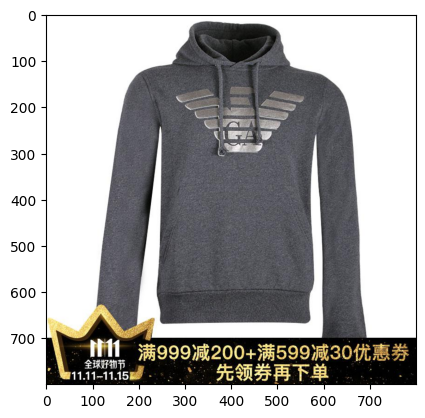

In [8]:
#df_g
import matplotlib.pyplot as plt
from PIL import Image

# Open the image file
img = Image.open(df_g.iloc[0]['path'])

# Display the image
plt.imshow(img)
plt.show()


Just to see;
AI-CROWD Dataset

In [9]:
df_g_sampled = df_g.sample(n=10000, random_state=1)

In [10]:
training_samples = []
values_counts = []
num_classes = 0

In [11]:
for group in tqdm(set(df_g_sampled['class'])):
    names = list(df_g_sampled.path[df_g_sampled['class'] == group])
    if len(names) >= CFG.min_samples:
        paths = [
            name for name in names[:CFG.samples_per_class]
        ]

        values_counts.append(len(paths))
        training_samples.extend([
            (p, num_classes) for p in paths
        ])
        
        num_classes += 1

/tmp/ipykernel_32/2783252197.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for group in tqdm(set(df_g_sampled['class'])):


  0%|          | 0/5854 [00:00<?, ?it/s]

In [12]:
data_train = training_samples 
value_counts = np.array(values_counts)
CFG.n_classes = num_classes


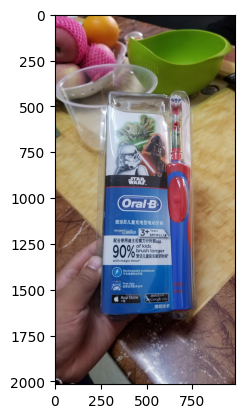

In [13]:
from PIL import Image
import matplotlib.pyplot as plt

# Open the image file
img = Image.open(data_train[500][0])

# Display the image
plt.imshow(img)
plt.show()


## MOdel Development Train and Validation

### Clip Model

Define PyTorch models for the head of the Neura Network- for customizing the final layers of a deep learning model. 
Model expansion.

- |__ **self.emb**: Linear (fully connected) layer - projects the input features to a lower-dimensional space (embedding space)
- ||__ **self.dropout**: Custom dropout layer- dropout mask with multiple dropout rates.
- |||__ **self.arc**: ArcMarginProduct layer - metric learning and class separation. It applies an adaptive margin-based loss to the embeddings.


In [14]:
class Head(nn.Module):
    def __init__(self, hidden_size, k=3):
        super(Head, self).__init__()
        self.emb = nn.Linear(hidden_size, CFG.emb_size, bias=False)
        self.dropout = utilities.Multisample_Dropout()
        self.arc = utilities.ArcMarginProduct_subcenter(CFG.emb_size, CFG.n_classes, k)
        
    def forward(self, x):
        embeddings = self.dropout(x, self.emb)
        output = self.arc(embeddings)
        return output, F.normalize(embeddings)
    
class HeadV2(nn.Module):
    def __init__(self, hidden_size, k=3):
        super(HeadV2, self).__init__()
        self.arc = utilities.ArcMarginProduct_subcenter(hidden_size, CFG.n_classes, k)
        
    def forward(self, x):
        output = self.arc(x)
        return output, F.normalize(x)
    
class HeadV3(nn.Module):
    def __init__(self, hidden_size, k=3):
        super(HeadV3, self).__init__()        
        self.emb = nn.Linear(hidden_size, CFG.emb_size, bias=False)
        self.dropout = nn.Dropout1d(0.2)
        self.arc = utilities.ArcMarginProduct_subcenter(CFG.emb_size, CFG.n_classes, k)
        
    def forward(self, x):
        x = self.dropout(x)
        x = self.emb(x)
        output = self.arc(x)
        return output, F.normalize(x)

### MOdel Development 

In [15]:
class Model(nn.Module):
    def __init__(self, vit_backbone, head_size, version='v1', k=3):
        super(Model, self).__init__()
        if version == 'v1':
            self.head = Head(head_size, k)
        elif version == 'v2':
            self.head = HeadV2(head_size, k)
        elif version == 'v3':
            self.head = HeadV3(head_size, k)
        else:
            self.head = Head(head_size, k)
        
        self.encoder = vit_backbone.visual
    def forward(self, x):
        x = self.encoder(x)
        return self.head(x)

    def get_parameters(self):

        parameter_settings = [] 
        parameter_settings.extend(
            self.get_parameter_section(
                [(n, p) for n, p in self.encoder.named_parameters()], 
                lr=CFG.vit_bb_lr, 
                wd=CFG.vit_bb_wd
            )
        ) 

        parameter_settings.extend(
            self.get_parameter_section(
                [(n, p) for n, p in self.head.named_parameters()], 
                lr=CFG.hd_lr, 
                wd=CFG.hd_wd
            )
        ) 

        return parameter_settings

    def get_parameter_section(self, parameters, lr=None, wd=None): 
        parameter_settings = []


        lr_is_dict = isinstance(lr, dict)
        wd_is_dict = isinstance(wd, dict)

        layer_no = None
        for no, (n,p) in enumerate(parameters):
            
            for split in n.split('.'):
                if split.isnumeric():
                    layer_no = int(split)
            
            if not layer_no:
                layer_no = 0
            
            if lr_is_dict:
                for k,v in lr.items():
                    if layer_no < int(k):
                        temp_lr = v
                        break
            else:
                temp_lr = lr

            if wd_is_dict:
                for k,v in wd.items():
                    if layer_no < int(k):
                        temp_wd = v
                        break
            else:
                temp_wd = wd

            weight_decay = 0.0 if 'bias' in n else temp_wd

            parameter_setting = {"params" : p, "lr" : temp_lr, "weight_decay" : temp_wd}

            parameter_settings.append(parameter_setting)

            #print(f'no {no} | params {n} | lr {temp_lr} | weight_decay {weight_decay} | requires_grad {p.requires_grad}')

        return parameter_settings

In [16]:
def ArcFace_criterion(logits_m, target, margins):
    #print("Labels:", target)
    #print("Valid Margins:", margins)
    arc = utilities.ArcFaceLossAdaptiveMargin(margins=margins, s=CFG.s, crit=CFG.crit)
    loss_m = arc(logits_m, target, CFG.n_classes)
    return loss_m

### Train Model & Validation Model


Given by the baseline code.
Optimized it
[train.py](https://gitlab.aicrowd.com/bartosz_ludwiczuk/visual-product-recognition-2023-starter-kit/-/blob/c0cb20339bc7443b83e62130d7ae3451a7d21a4e/MCS2023_baseline/train.py)

In [17]:
def train(model, train_loader, optimizer, scaler, scheduler, epoch):
    
    """
    Model training function for one epoch
    :param model: model architecture
    :param train_loader: dataloader for batch generation
    :param criterion: selected criterion for calculating the loss function
    :param optimizer: selected optimizer for updating weights
    :param config: train process configuration
    :param epoch (int): epoch number
    :return: None
    """

    
    model.train()
    loss_metrics = utilities.AverageMeter()
    criterion = ArcFace_criterion

    tmp = np.sqrt(1 / np.sqrt(value_counts))
    margins = (tmp - tmp.min()) / (tmp.max() - tmp.min()) * CFG.m + CFG.m_min
        
    bar = tqdm(train_loader)
    for step, data in enumerate(bar):
        step += 1
        images = data['images'].to(CFG.device, dtype=torch.float)
        labels = data['labels'].to(CFG.device)
        batch_size = labels.size(0)
        
        with torch.cuda.amp.autocast(enabled=CFG.autocast):
            outputs, features = model(images)

        loss = criterion(outputs, labels//25, margins)
        loss_metrics.update(loss.item(), batch_size)
        loss = loss / CFG.acc_steps
        scaler.scale(loss).backward()

        if step % CFG.acc_steps == 0 or step == len(bar):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()
            CFG.global_step += 1
                        
        lrs = utilities.get_lr_groups(optimizer.param_groups)

        loss_avg = loss_metrics.avg

        bar.set_postfix(loss=loss_avg, epoch=epoch, lrs=lrs, step=CFG.global_step)

        
#wrapper, same inside repeated
@torch.no_grad()
def validation(model, valid_loader):
    
    """
    Model validation function for one epoch
    :param model: model architecture
    :param val_loader: dataloader for batch generation
    :param criterion: selected criterion for calculating the loss function
    :param epoch (int): epoch number
    :return: float: avg acc
     """

    
    model.eval() 

    all_embeddings = []
    all_labels = [] 

    for data in tqdm(valid_loader):
        images = data['images'].to(CFG.device, dtype=torch.float)
        labels = data['labels'].to(CFG.device)

        _, embeddings = model(images)

        all_embeddings.append(embeddings.detach().cpu().numpy())
        all_labels.append(labels.detach().cpu().numpy())


    all_embeddings = np.concatenate(all_embeddings, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    return all_embeddings, all_labels



In [18]:
def training(train_loader, 
             gallery_loader, 
             query_loader, 
             experiment_folder, 
             version='v1', 
             k=3, 
             reduce_lr_on_epoch=1,
             use_rampup=True):
    
    
    
    backbone, _, _ = open_clip.create_model_and_transforms(CFG.model_name, CFG.model_data)

    model = Model(backbone, CFG.hidden_layer, version, k).to(CFG.device)
    
    optimizer = torch.optim.AdamW(model.get_parameters())
 
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.autocast)

    steps_per_epoch = math.ceil(len(train_loader) / 100* CFG.acc_steps)

    num_training_steps = math.ceil(CFG.n_epochs * steps_per_epoch)
    
    #print(backbone,model,optimizer,scaler,steps_per_epoch)
    
    if use_rampup:
        scheduler = get_cosine_schedule_with_warmup(optimizer,
                                                    num_training_steps=num_training_steps,
                                                    num_warmup_steps=CFG.n_warmup_steps)  
    else:
        scheduler = get_constant_schedule(optimizer)
        
    best_score = 0
    best_updated_ = 0
    CFG.global_step = 0     
    
    for epoch in range(math.ceil(CFG.n_epochs)):
        print(f'starting epoch {epoch}')

        # train of product-10k
        train(model, train_loader, optimizer, scaler, scheduler, epoch)
        #print('x')
        # aicrowd test data
        print('gallery embeddings')
        embeddings_gallery, labels_gallery = validation(model, gallery_loader)
        print('query embeddings')
        embeddings_query, labels_query = validation(model, query_loader)

        
        gc.collect()
        torch.cuda.empty_cache() 

        # calculate validation score
        _, indices = utilities.get_similiarity_l2(embeddings_gallery, embeddings_query, 1000)
        
        indices = indices.tolist()
        
        
        labels_gallery = labels_gallery.tolist()
        labels_query = labels_query.tolist()

        preds = utilities.convert_indices_to_labels(indices, labels_gallery)
        score = utilities.map_per_set(labels_query, preds)
        print('validation score', score)
        
        #save model
        #torch.save({'model_state_dict':model.state_dict(),}, f'{experiment_folder}/model_epoch_{epoch+1}_mAP3_{score:.2f}.pt')
        #torch.save(model)
        
        # early stopping
        if score > best_score:
            best_updated_ = 0
            best_score = score

        best_updated_ += 1

        if best_updated_ >= 3:
            print('no improvement done training....')
            break
            
        if (epoch + 1) % reduce_lr_on_epoch == 0:
            scheduler.base_lrs = [g['lr'] * CFG.reduce_lr for g in optimizer.param_groups]
            
        # to speed up the training
        if epoch >= 0:
            break
    return model

### Data Loaders

Define two functions read_img::reading and preprocessing an image from a file and get_final_transform :: returns a sequence of image transformations that are commonly used in deep learning pipelines, particularly for image classification tasks

In [19]:
# data loader

def read_img(img_path, is_gray=False):
    mode = cv2.IMREAD_COLOR if not is_gray else cv2.IMREAD_GRAYSCALE
    img = cv2.imread(img_path, mode)
    if not is_gray:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def get_final_transform():  
    final_transform = T.Compose([
            T.Resize(
                size=(CFG.image_size, CFG.image_size), 
                interpolation=T.InterpolationMode.BICUBIC,
                antialias=True),
            T.ToTensor(), 
            T.Normalize(
                mean=(0.48145466, 0.4578275, 0.40821073), 
                std=(0.26862954, 0.26130258, 0.27577711)
            )
        ])
    return final_transform


Defines a custom dataset class called ProductDataset. 
This class is designed to be used with PyTorch for creating 
a dataset of images and their corresponding labels, 
which can then be used with data loaders for training machine learning models



In [20]:
class ProductDataset(Dataset):
    def __init__(self, 
                 data, 
                 transform=None, 
                 final_transform=None):
        self.data = data
        self.transform = transform
        self.final_transform = final_transform
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
       
        img = read_img(self.data[idx][0])            
        
        if self.transform is not None:
            if isinstance(self.transform, A.Compose):
                img = self.transform(image=img)['image']
            else:
                img = self.transform(img)
        
        if self.final_transform is not None:
            if isinstance(img, np.ndarray):
                img =  Image.fromarray(img)
            img = self.final_transform(img)
            
        product_id = self.data[idx][1]
        return {"images": img, "labels": product_id}

- ImageNet-style data augmentation refers to the application of certain transformations to images in the ImageNet dataset to artificially expand the size of the training dataset. These transformations can include simple techniques such as cropping, rotating, and flipping input images.
- AugMix is a data augmentation technique that improves the robustness and uncertainty estimates of image classifiers1. It is characterized by its utilization of simple augmentation operations in concert with a consistency loss1.
- happy_whale data augmentation technique include rotations, scaling, color adjustments, and other transformations.
- cut_out data augmentation,involves removing rectangular regions from images
- clip data augmentation involving resizing and cropping.
- clip+image_net Combines CLIP-style resizing and cropping with ImageNet-style data augmentation.

[Data Augmentation](https://arxiv.org/abs/1712.04621v1)

In [21]:
"""
generates a PyTorch DataLoader object 
for training a deep learning model with an image dataset. 
This function is used to create a data loader for a dataset, 
with the option to apply different data augmentation strategies
"""
def get_product_10k_dataloader(data_train, data_aug='image_net'):
#def get_product_10k_dataloader(data_train, data_aug=None):
    
    transform = None
    #ImageNet-style data augmentation
    if data_aug == 'image_net':
        transform = T.Compose([
            T.ToPILImage(),
            T.AutoAugment(T.AutoAugmentPolicy.IMAGENET)
        ])
    #
    elif data_aug == 'aug_mix':
        transform = T.Compose([
            T.ToPILImage(),
            T.AugMix()
        ])
    #
    elif data_aug == 'happy_whale':
        aug8p3 = A.OneOf([
            A.Sharpen(p=0.3),
            A.ToGray(p=0.3),
            A.CLAHE(p=0.3),
        ], p=0.5)

        transform = A.Compose([
            A.ShiftScaleRotate(rotate_limit=15, scale_limit=0.1, border_mode=cv2.BORDER_REFLECT, p=0.5),
            A.Resize(CFG.image_size, CFG.image_size),
            aug8p3,
            A.HorizontalFlip(p=0.5),
            A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1)
        ])
    #
    elif data_aug == 'cut_out':        
        transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.ImageCompression(quality_lower=99, quality_upper=100),
            A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=10, border_mode=0, p=0.7),
            A.Resize(CFG.image_size, CFG.image_size),
            A.Cutout(max_h_size=int(CFG.image_size * 0.4), 
                     max_w_size=int(CFG.image_size * 0.4), 
                     num_holes=1, p=0.5),
        ])
    elif data_aug == 'clip':
        transform = T.Compose([
            T.ToPILImage(),
            T.RandomResizedCrop(
                size=(224, 224), 
                scale=(0.9, 1.0), 
                ratio=(0.75, 1.3333), 
                interpolation=T.InterpolationMode.BICUBIC,
                antialias=True
            )
        ])
    elif data_aug == 'clip+image_net':
        transform = T.Compose([
            T.ToPILImage(),
            T.AutoAugment(T.AutoAugmentPolicy.IMAGENET),
            T.RandomResizedCrop(
                size=(224, 224), 
                scale=(0.9, 1.0), 
                ratio=(0.75, 1.3333), 
                interpolation=T.InterpolationMode.BICUBIC,
                antialias=True
            )
        ])
    
    final_transform = get_final_transform()
    train_dataset = ProductDataset(data_train, 
                                   transform, 
                                   final_transform)
    train_loader = DataLoader(train_dataset, 
                              batch_size = CFG.train_batch_size, 
                              num_workers=CFG.workers, 
                              shuffle=True, 
                              drop_last=True)
    print(f'Training Data -> Dataset Length ({len(train_dataset)})')
    return train_loader


In [22]:
def aicrowd_data_loader(csv_path, img_dir='/kaggle/input/products-10k/products-10k/development_test_data'):
    df_g = pd.read_csv(csv_path)
    df_g_ = df_g[['img_path', 'product_id']]
    df_g_['img_path'] = df_g_.apply(lambda x: img_dir + '/' + x['img_path'], axis=1)
    data_ = np.array(df_g_).tolist()
    
    final_transform = get_final_transform()
    dataset = ProductDataset(data_, None, final_transform)
    data_loader = DataLoader(dataset, 
                             batch_size = CFG.valid_batch_size, 
                             num_workers=CFG.workers, 
                             shuffle=False, 
                             drop_last=False)
    
    print(f'{csv_path} -> Dataset Length ({len(dataset)})')
    return data_loader

### AI-CROWD Dataset

In [23]:
gallery_loader = aicrowd_data_loader('/kaggle/input/products-10k/products-10k/development_test_data/gallery.csv') 
query_loader = aicrowd_data_loader('/kaggle/input/products-10k/products-10k/development_test_data/queries.csv')


/kaggle/input/products-10k/products-10k/development_test_data/gallery.csv -> Dataset Length (1067)
/kaggle/input/products-10k/products-10k/development_test_data/queries.csv -> Dataset Length (1935)


/tmp/ipykernel_32/4081245786.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_g_['img_path'] = df_g_.apply(lambda x: img_dir + '/' + x['img_path'], axis=1)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/tmp/ipykernel_32/4081245786.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

Set up and start the training process for a deep learning model, 

### --Training Start Here--

In [24]:
k = 3  
version = 'v2'
#data_aug = None
data_aug = 'image_net'
CFG.reduce_lr = 0.1
train_loader = get_product_10k_dataloader(data_train, data_aug)
experiment_folder = f'my_experiments/{CFG.model_name}-{CFG.model_data}-{str(data_aug)}-{str(version)}-p10k-Arcface(k={str(k)})-All-Epoch({str(CFG.n_epochs)})-Reduce_LR_0.1'
print(experiment_folder)
model=training(train_loader, 
         gallery_loader, 
         query_loader, 
         experiment_folder, 
         version=version,
         k=k)

gc.collect()
torch.cuda.empty_cache()


Training Data -> Dataset Length (1523)
my_experiments/ViT-H-14-laion2b_s32b_b79k-image_net-v2-p10k-Arcface(k=3)-All-Epoch(10)-Reduce_LR_0.1


starting epoch 0


/tmp/ipykernel_32/1422416541.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  bar = tqdm(train_loader)


  0%|          | 0/380 [00:00<?, ?it/s]

gallery embeddings


/tmp/ipykernel_32/1422416541.py:70: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for data in tqdm(valid_loader):


  0%|          | 0/134 [00:00<?, ?it/s]

query embeddings


  0%|          | 0/242 [00:00<?, ?it/s]

Processing indices...
Finished processing indices, took 0.30257582664489746s
validation score 0.2754780361757106


### ---Final Phase---

In [ ]:
gallery_embeddings, _ = validation(model, gallery_loader)
query_embeddings, _ = validation(model, query_loader)

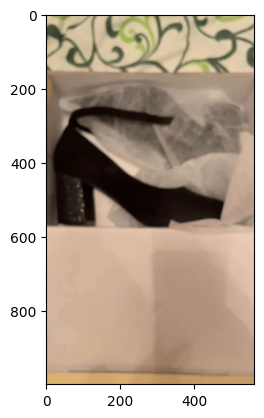

/tmp/ipykernel_32/1422416541.py:70: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for data in tqdm(valid_loader):


  0%|          | 0/134 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/242 [00:00<?, ?it/s]

Processing indices...
Finished processing indices, took 0.0019402503967285156s


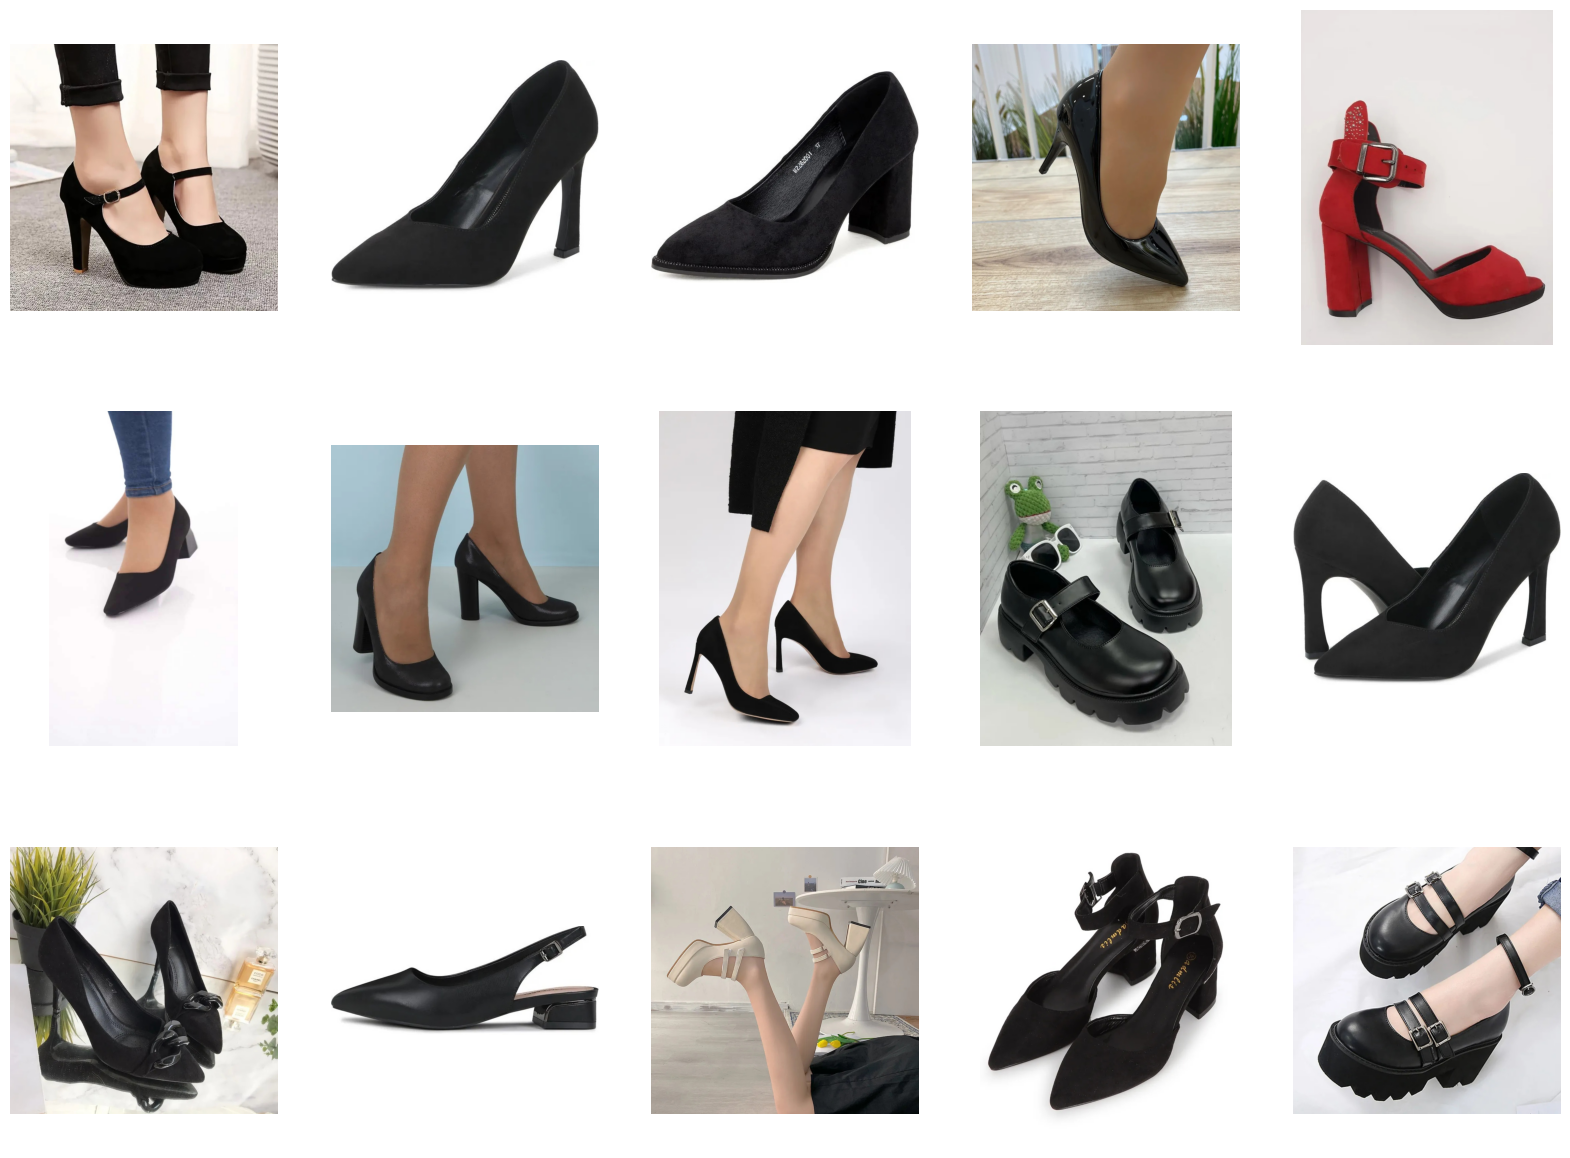

In [31]:
#im_num=500 ##rememberdddd
##Please don't change this 2-lines
im_num= 500

import torch.optim as optim
from IPython.display import Image
from torch.utils.data import DataLoader, Dataset

from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from PIL import Image
import matplotlib.pyplot as plt

gallery_df = pd.read_csv("/kaggle/input/products-10k/products-10k/development_test_data/gallery.csv")
gallery_df['path'] = gallery_df.apply(lambda x: '/kaggle/input/products-10k/products-10k/development_test_data' + '/' + x['img_path'], axis=1)

queries_df = pd.read_csv("/kaggle/input/products-10k/products-10k/development_test_data/queries.csv")
queries_df['path'] = queries_df.apply(lambda x: '/kaggle/input/products-10k/products-10k/development_test_data' + '/' + x['img_path'], axis=1)


img_q = Image.open(queries_df.loc[im_num]['path'])
plt.imshow(img_q)
plt.show()


embd_img = query_embeddings[im_num]
#_, indices = utilities.get_similiarity_l2(gallery_embeddings,embd_img , k)

# Reshape embd_img into a 2D array
embd_img_2d = embd_img.reshape(1, -1)

# Find the most similar images in the gallery for the query image
_, indices = utilities.get_similiarity_l2(gallery_embeddings, embd_img_2d, k=15)

# Flatten indices into a 1D list
flat_indices = [index for sublist in indices for index in sublist]
# Use flat_indices to select rows
similar_images = gallery_df.loc[flat_indices]
import matplotlib.pyplot as plt
from PIL import Image

# Create a new figure
fig = plt.figure(figsize=(20, 20))

# Loop over each row in the DataFrame
for i, row in enumerate(similar_images.iterrows()):
    # Open the image file
    img = Image.open(row[1]['path'])
    
    # Add a subplot for the current image
    ax = fig.add_subplot(4, 5, i + 1)
    
    # Display the image in the subplot
    ax.imshow(img)
    
    # Remove the axis
    ax.axis('off')

# Display the figure with all images
plt.show()


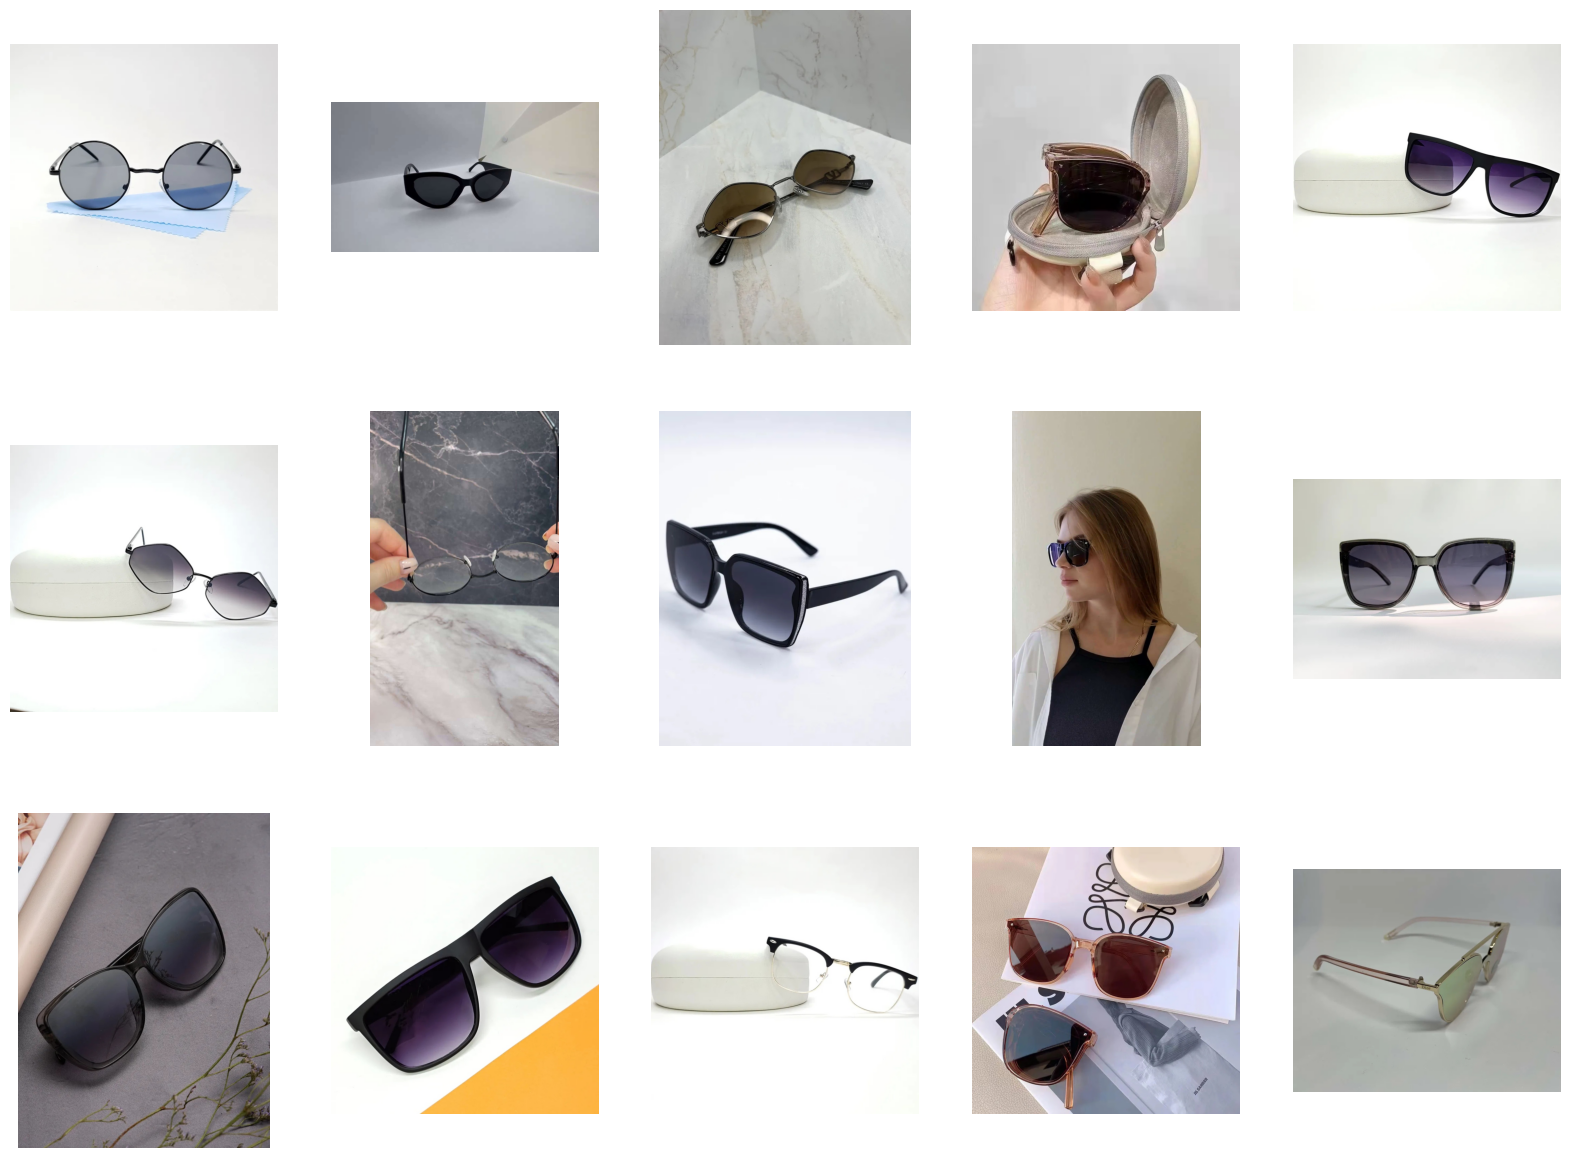

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from multiprocessing import Pool

# Preload all images into a list
all_images = [Image.open(path) for path in gallery_df['path']]

def load_image(i):
    return all_images[i]

# Use parallel processing to load images
with Pool() as p:
    images = p.map(load_image, flat_indices)

# Create a new figure
fig = plt.figure(figsize=(20, 20))

# Loop over each image
for i, img in enumerate(images):
    # Add a subplot for the current image
    ax = fig.add_subplot(4, 5, i + 1)
    
    # Display the image in the subplot
    ax.imshow(img)
    
    # Remove the axis
    ax.axis('off')

# Display the figure with all images
plt.show()


Code is not predicting labels for new data. Instead, it’s using the model to find similar images based on their embeddings

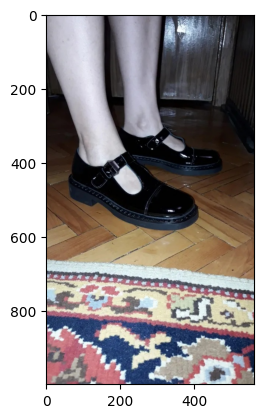

Processing indices...
Finished processing indices, took 0.0015461444854736328s


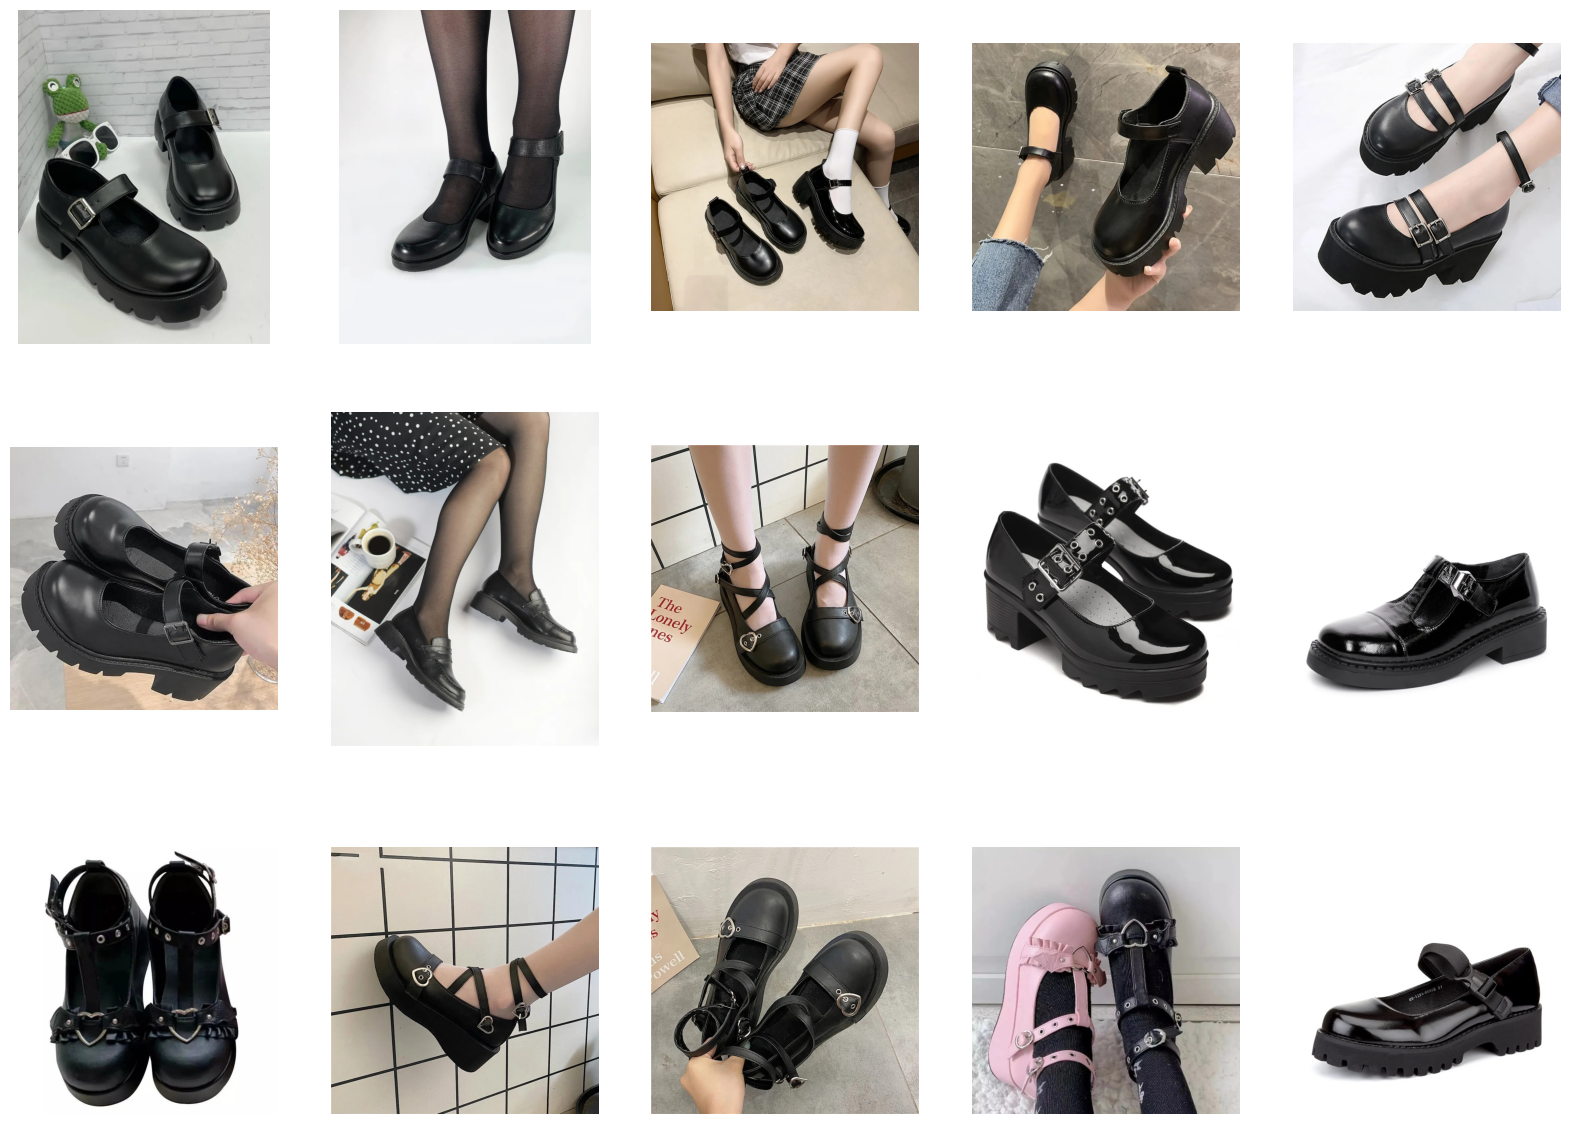

In [45]:
import torch.optim as optim
from IPython.display import Image
from torch.utils.data import DataLoader, Dataset

from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from PIL import Image
import matplotlib.pyplot as plt

gallery_df = pd.read_csv("/kaggle/input/products-10k/products-10k/development_test_data/gallery.csv")
gallery_df['path'] = gallery_df.apply(lambda x: '/kaggle/input/products-10k/products-10k/development_test_data' + '/' + x['img_path'], axis=1)

queries_df = pd.read_csv("/kaggle/input/products-10k/products-10k/development_test_data/queries.csv")
queries_df['path'] = queries_df.apply(lambda x: '/kaggle/input/products-10k/products-10k/development_test_data' + '/' + x['img_path'], axis=1)

im_num=58
img_q = Image.open(queries_df.loc[im_num]['path'])
plt.imshow(img_q)
plt.show()

embd_img = query_embeddings[im_num]

# Reshape embd_img into a 2D array
embd_img_2d = embd_img.reshape(1, -1)

# Find the most similar images in the gallery for the query image
_, indices = utilities.get_similiarity_l2(gallery_embeddings, embd_img_2d, k=15)

# Flatten indices into a 1D list
flat_indices = [index for sublist in indices for index in sublist]
# Use flat_indices to select rows
similar_images = gallery_df.loc[flat_indices]

# Initialize an empty dictionary
image_dict = {}

# Loop over each row in the DataFrame
for i, row in enumerate(similar_images.iterrows()):
    # Get the image path
    img_path = row[1]['path']
    
    # Get the corresponding feature vector from gallery_embeddings
    feature_vector = gallery_embeddings[flat_indices[i]]
    
    # Add the image path and feature vector to the dictionary
    image_dict[img_path] = feature_vector

# Now image_dict contains all the similar images' locations and their corresponding feature vectors

import matplotlib.pyplot as plt
from PIL import Image

# Create a new figure
fig = plt.figure(figsize=(20, 20))

# Loop over each row in the DataFrame
for i, row in enumerate(similar_images.iterrows()):
    # Open the image file
    img = Image.open(row[1]['path'])
    
    # Add a subplot for the current image
    ax = fig.add_subplot(4, 5, i + 1)
    
    # Display the image in the subplot
    ax.imshow(img)
    
    # Remove the axis
    ax.axis('off')

# Display the figure with all images
plt.show()


In [36]:
# Preload all images into a list
all_images = [Image.open(path) for path in gallery_df['path']]

Processing indices...
Finished processing indices, took 0.0015401840209960938s


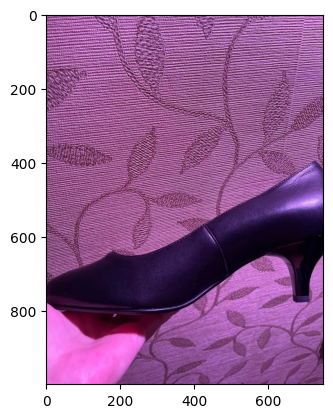

In [42]:
im_num = 801
embd_img = query_embeddings[im_num]

# Reshape embd_img into a 2D array
embd_img_2d = embd_img.reshape(1, -1)

# Find the most similar images in the gallery for the query image
_, indices = utilities.get_similiarity_l2(gallery_embeddings, embd_img_2d, k=15)


img_q = Image.open(queries_df.loc[im_num]['path'])
plt.imshow(img_q)
plt.show()

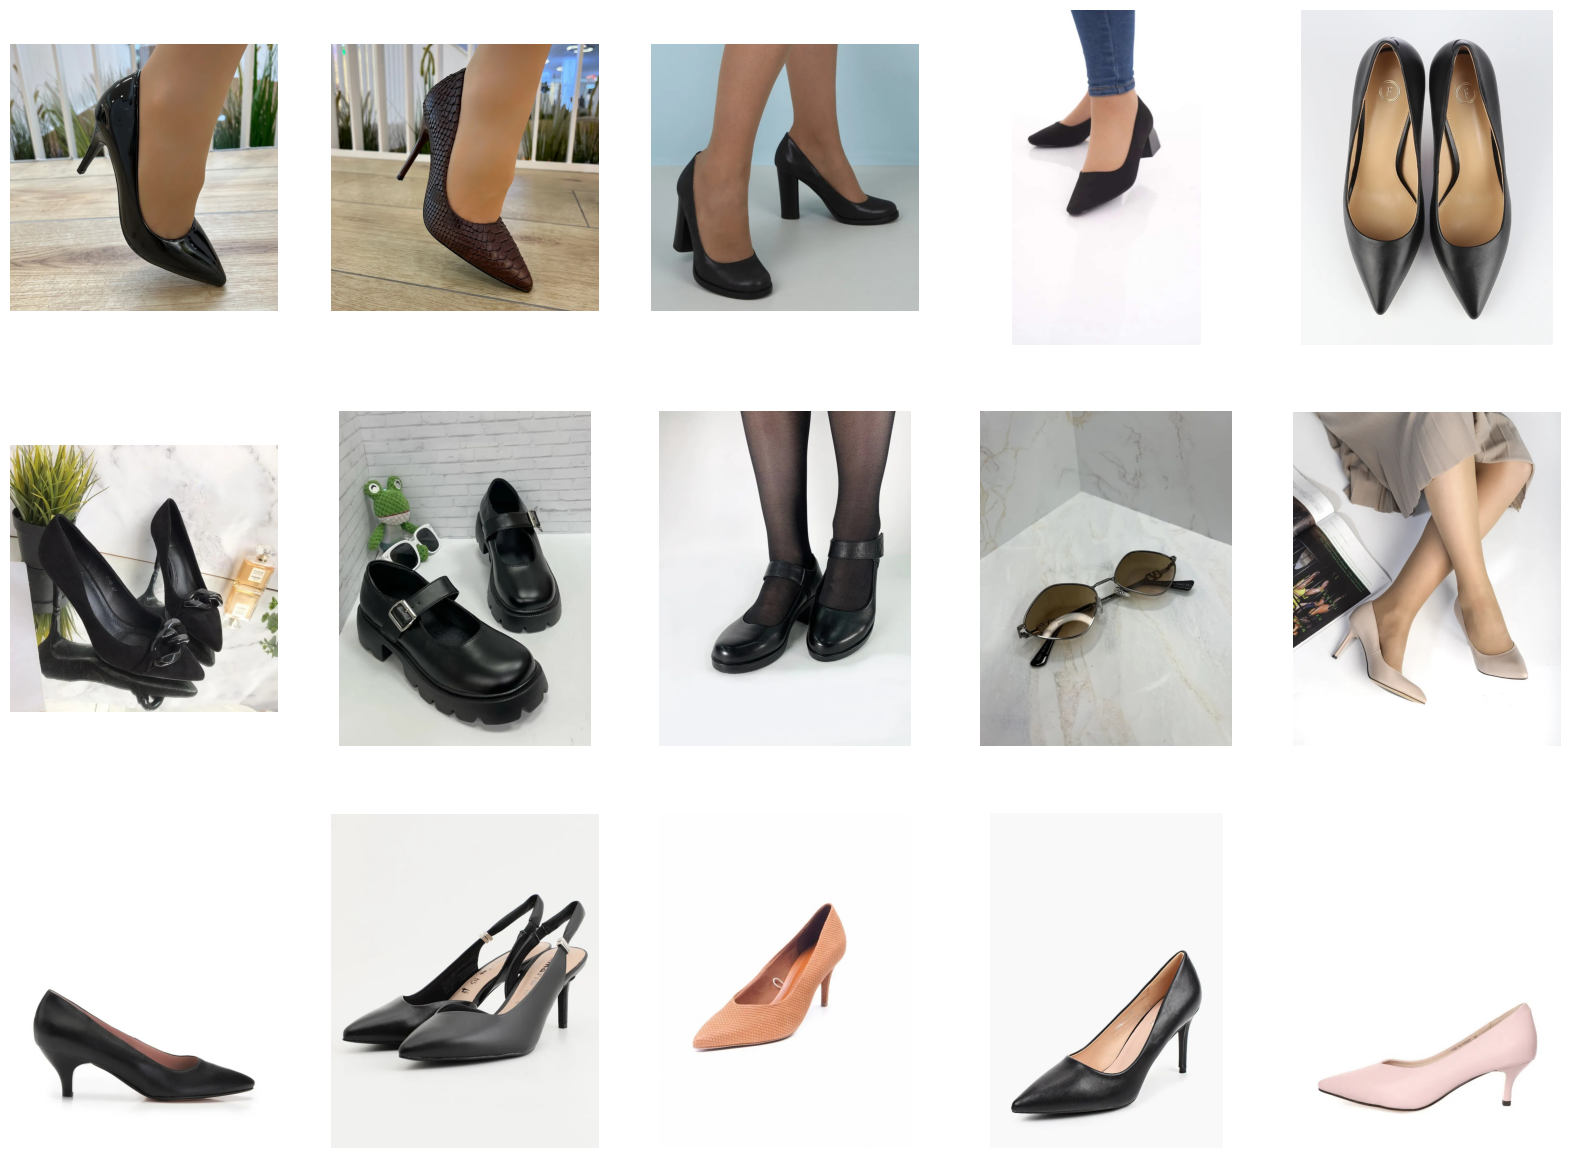

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from multiprocessing import Pool


# Flatten indices into a 1D list
flat_indices = [index for sublist in indices for index in sublist]
# Use flat_indices to select rows



def load_image(i):
    return all_images[i]

# Use parallel processing to load images
with Pool() as p:
    images = p.map(load_image, flat_indices)

# Create a new figure
fig = plt.figure(figsize=(20, 20))

# Loop over each image
for i, img in enumerate(images):
    # Add a subplot for the current image
    ax = fig.add_subplot(4, 5, i + 1)
    
    # Display the image in the subplot
    ax.imshow(img)
    
    # Remove the axis
    ax.axis('off')

# Display the figure with all images
plt.show()
